# Hand-in 3, Part 1: Data handling and exploration

In this first notebook you will show us how you handle data being separated over several files, as well as exploring the quality and properties of your data.

#### Section 1: bash scripting

You have downloaded a zip file containing 5 CSV files, each containing part of the data you need. First, use your bash tools to look at the headers and size of the file. What do the different files contain?

Write a bash script that concatenates the 4 data files (except the flow_criticality_data.csv file). Exlain in the markdown cell below, what each part of your script does.

In [ ]:
#!/bin/bash

# find files mathcing strng in argument 1
#files=(`find . -name '*'$1'*'`)

# Make your own list of files
files=(energy_demand_data.csv exchange_data.csv generator_production_data.csv renewable_production_data.csv)

# remove the time stamp for all 
cut -d ',' -f1 --complement "${files[@]:1}" > temp.csv

# collect the files to one
paste -d ',' "${files[@]:0}" "temp.csv" 

#removes temp.csv
rm temp.csv

**Q#1** *Explain your script here (by double clicking on this text).*
The script consits of three steps.

1. First you must tell the script which files to use. This can be done with by serching for a keyword or by manually inutting the list into the script.

2. Next, the script will remove the first column in all but the 


8784,37

(8784, 21)

(8784, 52)
(8784, 30)





## Section 2: Visualizing the data
Here you will plot the resulting data file from the previous section, and plot it in order to identify missing data and see if you can already draw some conclusions on the data.

* *Hint: remember the hint given in Exc.13.3, on how to find out if your data contains NaN values*

In [9]:
# You will probably be needing the following libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import numpy as np

In [12]:
# Import your data here
df = pd.Series()
df['raw'] = pd.read_csv('concatenated.csv')
df['raw'] = df['raw'].set_index('time')
df['raw'].shape

(8784, 136)

<IPython.core.display.Javascript object>


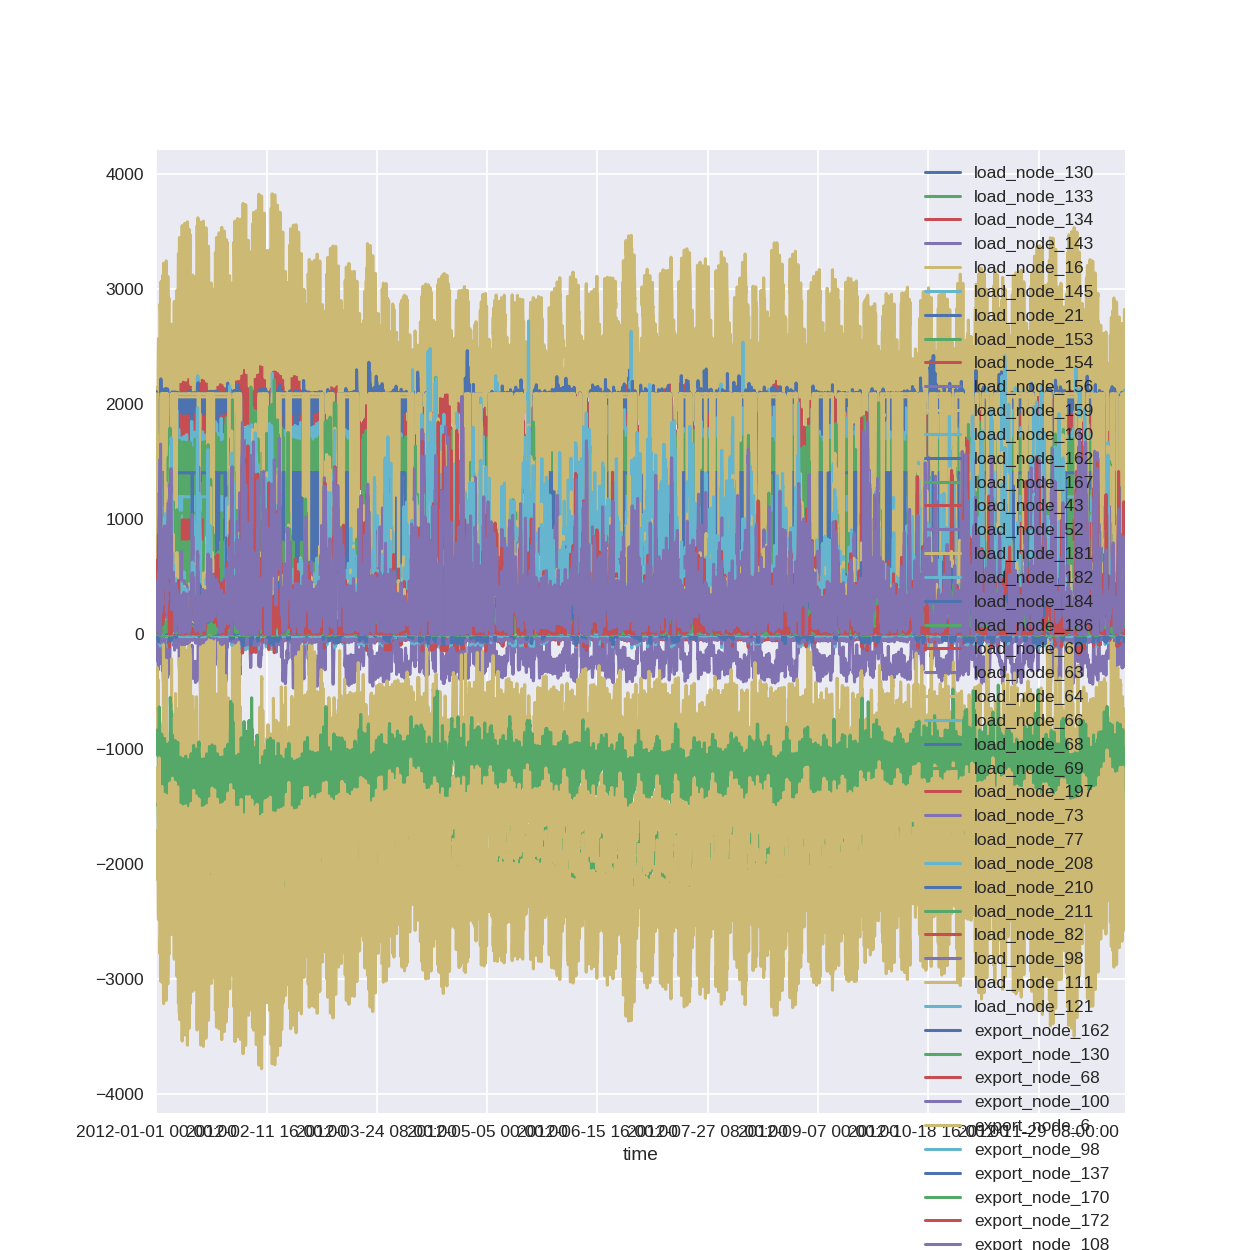

In [13]:
# First do some time series plots on the data, would it be practical to plot all possible scatter plots (scatter matrix)?
df['raw'].plot(figsize=(10,10));

<IPython.core.display.Javascript object>


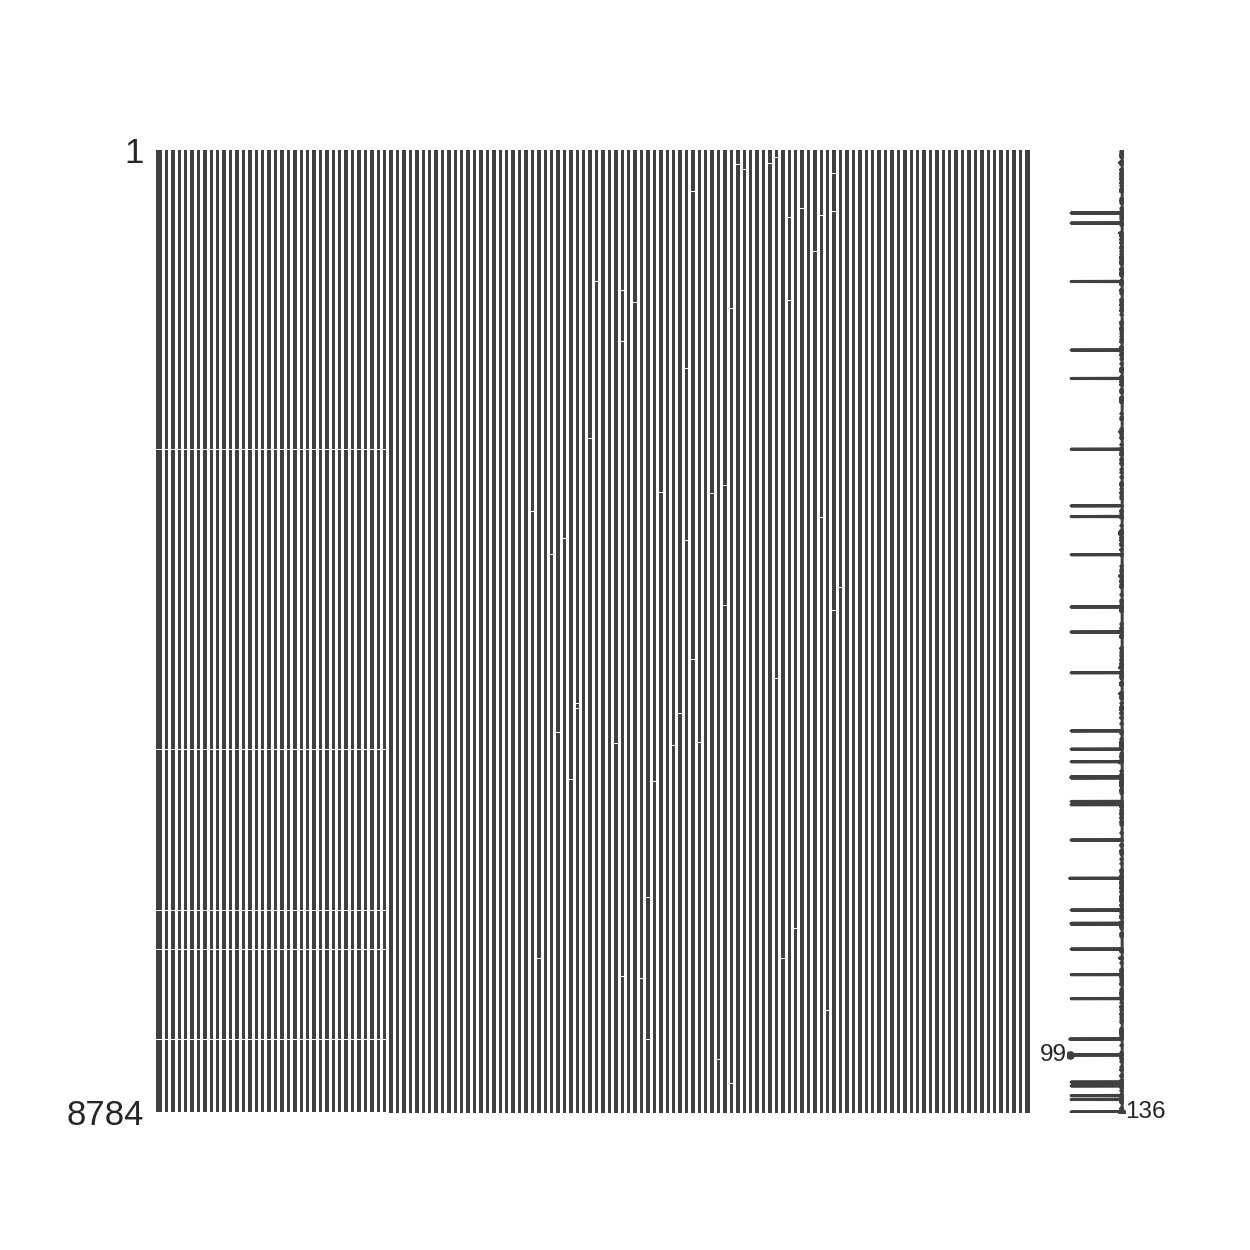

1711 lines contains nans


In [14]:
import missingno as msno
msno.matrix(df['raw'],figsize=(10,10))
print(df['raw'].isnull().values.ravel().sum(), 'lines contains nans')

**Q#2** For this data, what is the reasonable approach to dealing with the NaN values? Why?

The timeseries plot, has alot of information to it.
It is too messy, and there are too many columns to get alot of information from it, but it seems like the generel trend of the different attributes, are represented in the data.

By inspecting the missing value matrix, i see that the missing datapoints seem to be spread out.

Based on this information, the rows containing the missing values will be removed


<IPython.core.display.Javascript object>


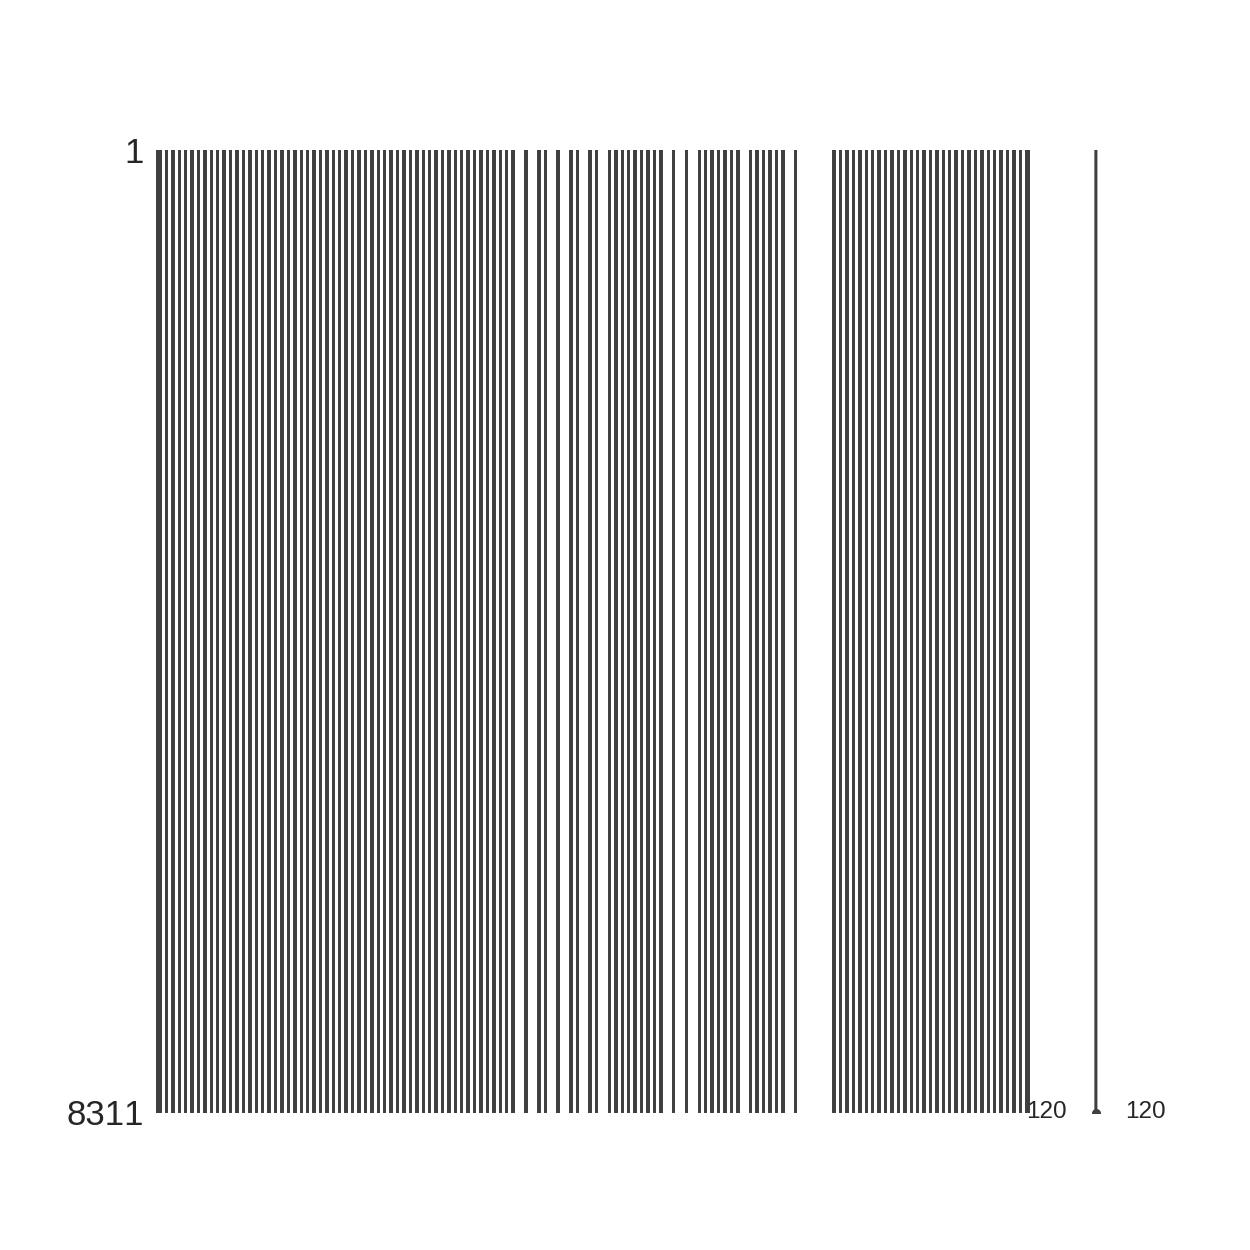

0.000000       16
88.632429       1
42.660538       1
181.299376      1
27.907998       1
300.373000      1
6.712768        1
242.163895      1
450.986285      1
86.052909       1
11.514559       1
317.545130      1
28.426264       1
442.222648      1
432.890913      1
295.218064      1
310.703411      1
11.146044       1
165.298071      1
69.227317       1
15.687234       1
7.233002        1
113.988681      1
37.491939       1
59.129867       1
38.029081       1
5.553895        1
147.918730      1
937.578148      1
86.387317       1
               ..
158.992153      1
9.522221        1
1005.063381     1
3.400159        1
85.527407       1
291.528576      1
366.117344      1
145.359241      1
319.343413      1
376.322203      1
301.459286      1
466.173530      1
62.348224       1
194.688226      1
222.767475      1
18.889989       1
53.198994       1
20.294060       1
0.417974        1
3.740444        1
76.585563       1
212.154792      1
12.914715       1
374.613125      1
72.557275 

In [21]:
# Get rid of your NaNs here
df['no_nan'] = df['raw'].dropna()

from scipy import stats
# standardize for PCA
df['std'] = ((df['no_nan']-df['no_nan'].mean())/df['no_nan'].std())
msno.matrix(df['std'],figsize=(10,10))
df['no_nan'].std().value_counts()

I see that 16 columns has a standard deviasion of  0, and thus becomes NaN when standardizing the data.
If the standard deviation is 0, these columns contains no usefull information, as this means all values are equal.
The columns will now be removed from the standardized data.

In [22]:
df['std']= df['std'].dropna(axis=1)

### Feature reduction
Since you must reduce the amount of sensors, you need to find out which ones you can get rid of. 

**Q#3** Why would PCA be useful for this?

In [23]:
from sklearn.decomposition import PCA

# Do your PCA here.
Ncomponents = 26
pca = PCA(n_components=Ncomponents)
pca.fit(df['std']);

pca.explained_variance_ratio_

array([ 0.33932605,  0.1964607 ,  0.05014847,  0.04480238,  0.03548778,
        0.0293469 ,  0.02373505,  0.01960364,  0.01877989,  0.01736071,
        0.01545376,  0.01254409,  0.01110511,  0.00960549,  0.00875978,
        0.00841727,  0.00818014,  0.0074923 ,  0.00718862,  0.00687235,
        0.00634839,  0.00598979,  0.00554669,  0.005247  ,  0.00508104,
        0.00461738])

### Scree plot
**Q#4** How many principal components do you need to explain 90 % of the variance? 

With 26 principal components, more than 90% of the variance in the data is explained

<IPython.core.display.Javascript object>


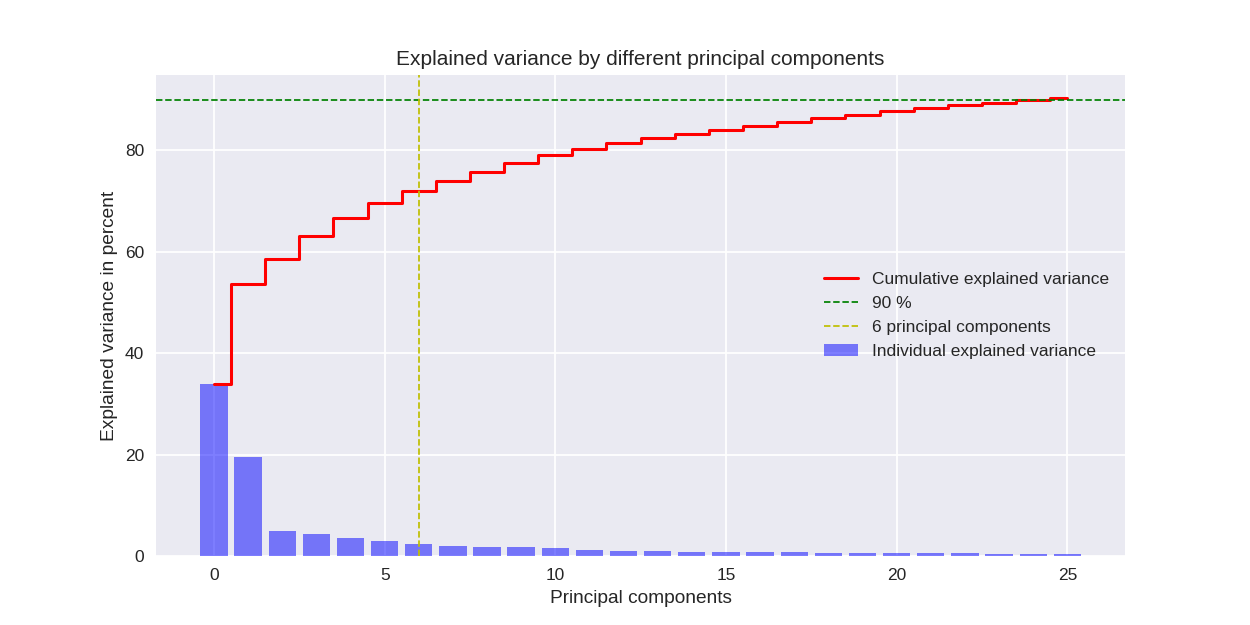

Explained variance with 26 principal components: 90.35007783910932 %


In [26]:
cum_var_explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(Ncomponents), pca.explained_variance_ratio_*100, alpha=0.5, align='center', label='Individual explained variance', color='b')
plt.step(range(Ncomponents), cum_var_explained*100 , where='mid', label='Cumulative explained variance', color='r')
plt.axhline(y=90, linewidth=1, color='g', linestyle='dashed', label='90 %')
plt.axvline(x=6, linewidth=1, color='y', linestyle='dashed', label='6 principal components')
plt.title('Explained variance by different principal components')
plt.ylabel('Explained variance in percent')
plt.xlabel('Principal components')
plt.legend(loc='center right')
plt.show()

print('Explained variance with 26 principal components: {} %'.format(sum(pca.explained_variance_ratio_[:26])*100))

### Clustering
You want to reduce the amount of field sensors to 20. You should now have from the previous question, an array with all your loading vectors (pca.components\_), one vector per principal component, with 137 elements (one per each sensor). Use clustering to group sensors that behave the same. 

**Q#5** How would you choose which sensors in each cluster you should keep?

<IPython.core.display.Javascript object>


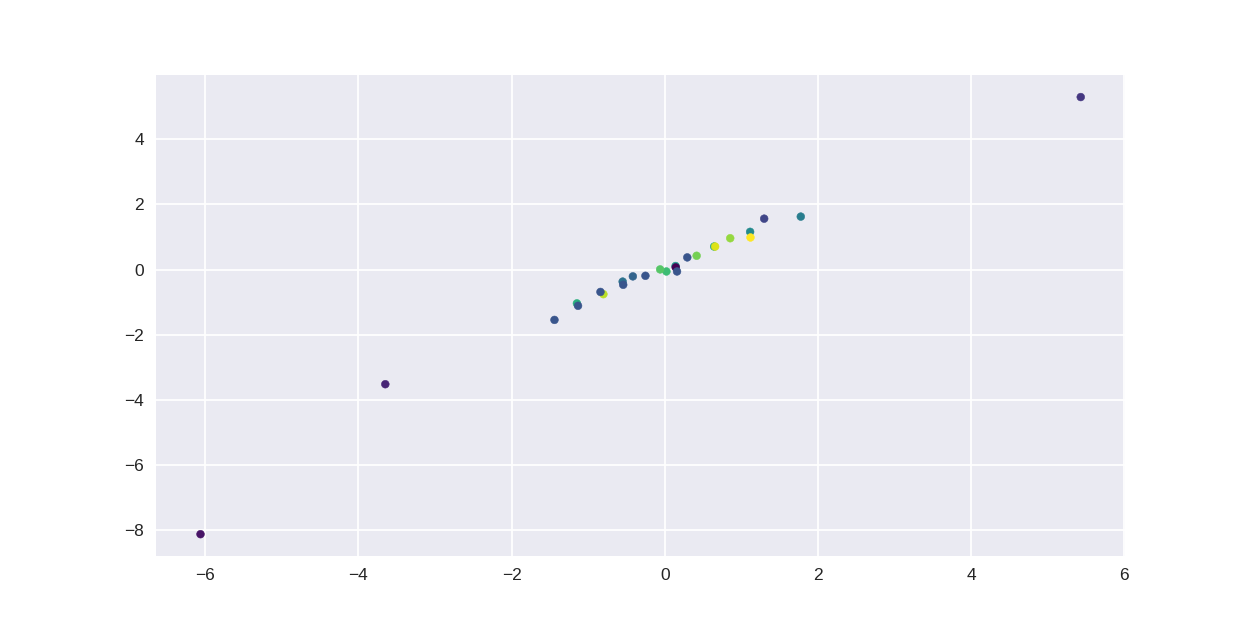

(8311, 26)

In [27]:
from sklearn.cluster import KMeans
X_pca = pca.transform(df['std'])

# Apply your clustering here
km = KMeans(n_clusters=20, init='k-means++',n_init=10, verbose=0);
km.fit(X_pca.T);
cluster_pred = km.predict(X_pca.T);

plt.figure(figsize=(10,5))
plt.scatter(X_pca[0], X_pca[1], c=cluster_pred, s=20, cmap='viridis')
plt.show()

X_pca.shape


### Save your chosen sensors

Now that you have chosen 20 sensors which are representative of your data, create a DataFrame that contains these sensors. You can save them to csv file using the code in the following cell.

In [ ]:
# Assuming of course that your reduced data set is called data_reduced
data_reduced.to_csv('reduced_field_data.csv')